# Analyse Big Data avec Google BigQuery et Pandas

Lorsqu'un set de données devient trop important pour un traitement sur votre machine (généralement au dessus de quelques Gigaoctets), il vous faut déporter vos calculs dans des infrastructures Cloud. 

La plateforme BigQuery s'appuie sur l'infrastructure de Google. Elle vous permet de stocker et de requêter des sets de données sans limite de taille. 

Dans cette partie, vous allez voir comment Pandas et BigQuery s'intègrent pour traiter, dans le cloud, des bases de données volumineuses. 

# BigQuery

Rendez vous sur l'interface - https://bigquery.cloud.google.com/ et créez le projet datawagon. 

Vous devrez renseigner vos coordonnées bancaires pour pouvoir activer votre compte. Vous bénéficiez par défaut d'une première période de test. Vous pouvez consulter les tarifs sur cette page - https://cloud.google.com/bigquery/pricing

Vous pouvez enfin modifier vos projets, leurs droits d'accés ainsi que vos informations de paiement au sein de votre console - https://console.developers.google.com/

Les projets auxquels vous avez accès sont affichés sur la gauche. Au sein de chaque projet vous retrouvez un ou plusieurs set de données. 

<img src='files/images/projets-bq.png'>

BigQuery offre également une interface de requêtage type SQL accessible depuis votre navigateur web : 

<img src='files/images/queries.png'>

Il vous est enfin possible d'importer vos propres données, en utilisant l'utilitaire d'import de données en ligne, ou en passant par la plateforme Google Cloud Storage. 

Dans cet exercice, nous allons utiliser le projet `bigquery-samples:airline_ontime_data.flights`.

Ce dataset est public et liste les informations de vols d'avion aux Etats Unis entre 2002 et 2012. Il contient 70+ millions de lignes et pèse environ 8Go. 

Vous  pouvons compter le nombre de lignes de ce dataset en exécutant la requête suivante : 

In [ ]:
SELECT COUNT(*) FROM [bigquery-samples:airline_ontime_data.flights]

Nous allons copier cette table, au sein de notre projet en utilisant l'option **copy table** accessible depuis le menu à droite de la table flights :

<img src='files/images/copy-table.png'>

## Let's do it ! Analysons 10 ans de vols aux Etats Unis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
from ggplot import *

In [ ]:
pd.options.display.mpl_style = 'default'

### Evolution temporelle

Pandas et BigQuery s'intègrent facilement grâce à la méthode **read_gbq**, encore en version expérimentale dans la version 0.16 de Pandas : 

In [ ]:
query = 'SELECT date,COUNT(*) as count FROM [vols.flights] GROUP BY date'

dates = pd.read_gbq(query,project_id='data-kit')

Les dates étant stockées sous forme de String au sein de BigQuery, nous créons un index en utilisant la méthode **pd.to_datetime()** :

In [ ]:
dates.head()

In [ ]:
dates.index = pd.to_datetime(dates['date'])

Nous pouvons ensuite apliquer notre méthode resample pour obtenir une vue du nombre de vols par mois :

In [ ]:
dates.resample('M',how='sum').plot()

En réalisant le même graphe avec une vue par aire, nous nous appercevons qu'il y a un trou de données en octobre 2012 : 

In [ ]:
dates.resample('M',how='sum').plot(ylim=[0,650000],kind='area')

Nous remarquons également la baisse tendancielles des vols à partir de 2008, coincidant avec les débuts de la crise économique.

## Cartographie des aéroports US

In [ ]:
import folium
from IPython.display import HTML

def inline_map(map):
    map._build_map()
    return HTML('<iframe srcdoc="{srcdoc}" style="width: 100%; height: 510px; border: none"></iframe>'.format(srcdoc=map.HTML.replace('"', '&quot;')))

En utilisant la librairie Folium que nous avons vu précédemment, nous pouvons cartographier le volume des principaux aéroports américains. 

In [ ]:
query_airport = 'SELECT departure_airport,departure_lat,departure_lon,COUNT(*) as count FROM [vols.flights] GROUP BY departure_airport,departure_lat,departure_lon'

airport = pd.read_gbq(query_airport,project_id='data-kit')

In [ ]:
airport.head()

In [ ]:
map_airport = folium.Map(location=[35,-80], zoom_start=3)

Afin de représenter les aéroports sous la forme de bulles dont la taille est fonction du nombre de vols à leur départ, nous allons appliquer une mise à l'échelle. 

In [ ]:
airport['size'] = (airport['count'] / np.max(airport['count'])) * 200000

In [ ]:
airport.sort('count',ascending=False).head()

In [ ]:
for x in airport.values:
    location = []
    location.append(x[1])
    location.append(x[2])
    map_airport.circle_marker(location,radius=x[4],fill_color='red',line_color='none',popup=x[0])

In [ ]:
inline_map(map_airport)

## Analyse du retard moyen

Nous pouvons analyser le retard moyen des vols en prenant par exemple le retard à par compagnie aérienne 

Cette requête peut s'écrire : 

In [34]:
query_delay_airline = 'SELECT airline,COUNT(*) AS count,AVG(arrival_delay) AS retard FROM [vols.flights] GROUP BY airline'

delay = pd.read_gbq(query_delay_airline,project_id='data-kit')

Job not yet complete...


In [35]:
delay.head()

,airline,count,retard
0,FL,2182427,6.962992
1,WN,11723133,4.314530
2,HP,768655,3.953741
3,DL,6607317,5.195066
4,OH,1698485,7.828057


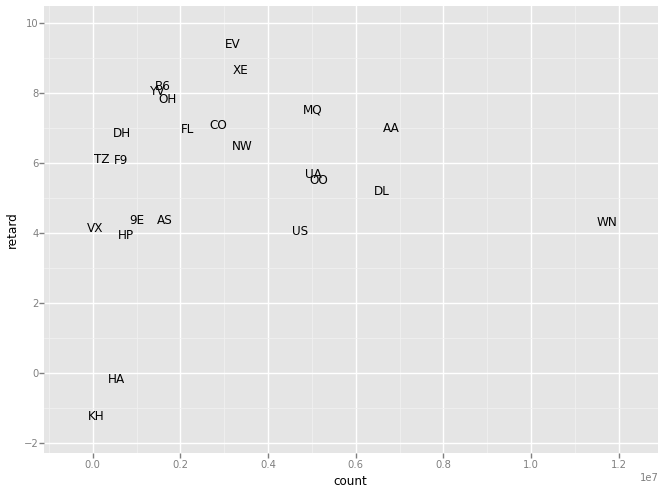

<ggplot: (286802781)>

In [36]:
ggplot(delay, aes(x='count', y='retard', label='airline')) +\
    geom_text()

Nous pouvons appliquer la même méthode par Etats, en prenant par exemple l'Etat d'arrivée

In [37]:
query_delay = 'SELECT arrival_state,COUNT(*) AS count,AVG(arrival_delay) AS retard FROM [vols.flights] GROUP BY arrival_state'

delay = pd.read_gbq(query_delay,project_id='data-kit')

Job not yet complete...


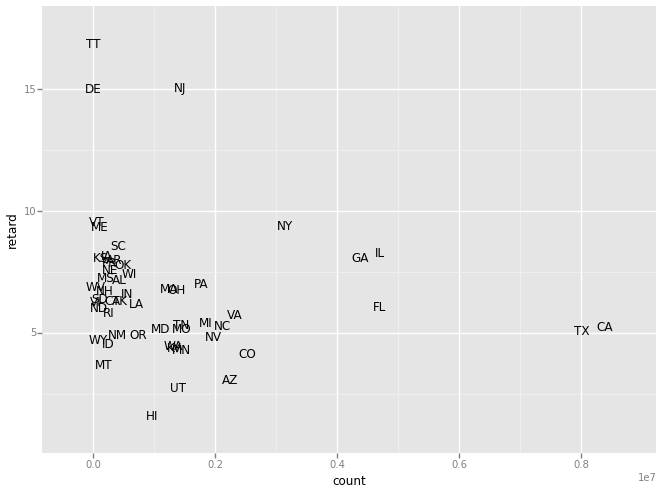

<ggplot: (285049065)>

In [38]:
ggplot(delay, aes(x='count', y='retard', label='arrival_state')) +\
    geom_text()

On peut également analyser les routes présentant le plus grand retard moyen.

On peut réaliser cela grâce à la requête : 

In [39]:
query_delay_interstate = 'SELECT departure_state,arrival_state,COUNT(*) AS count,AVG(arrival_delay) AS retard FROM [vols.flights] GROUP BY departure_state,arrival_state'

delay_interstate = pd.read_gbq(query_delay_interstate,project_id='data-kit')

Job not yet complete...


Nous obtenons que nous pouvons faire pivoter grâce à la méthode **pivot**

In [40]:
delay_interstate.head()

,departure_state,arrival_state,count,retard
0,CO,CO,277339,5.390623
1,AL,CO,8615,4.167266
2,OH,CO,30817,2.032677
3,NC,CO,21996,3.152028
4,TX,CO,261856,5.658564


In [42]:
delay_interstate.sort('count',ascending=True).head()

,departure_state,arrival_state,count,retard
1464,OK,LA,1,-17
1456,SC,AL,1,-23
1455,OR,WI,1,37
1491,NE,AL,1,25
336,SC,AR,1,60


In [43]:
delay_interstate2 = delay_interstate[delay_interstate['count'] > 10000]

In [44]:
pivot_airports = delay_interstate2.pivot('departure_state','arrival_state','retard').fillna(0)

In [45]:
pivot_airports.head()

arrival_state,AK,AL,AR,AZ,CA,CO,CT,FL,GA,HI,...,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY
departure_state,,,,,,,,,,,,,,,,,,,,,
AK,5.794051,0,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0,0,2.877099,0.000000,0,0
AL,0.000000,0,0,0.000000,0.000000,0.000000,0,4.698283,9.165816,0.000000,...,2.729115,4.480243,0.000000,5.678679,0,0,0.000000,0.000000,0,0
AR,0.000000,0,0,0.000000,0.000000,0.000000,0,0.000000,9.313172,0.000000,...,2.790402,6.012904,0.000000,0.000000,0,0,0.000000,0.000000,0,0
AZ,0.000000,0,0,1.269977,4.320855,3.390485,0,2.471156,2.219686,2.412271,...,2.859147,4.075065,3.154835,3.985470,0,0,3.575726,4.526789,0,0
CA,0.000000,0,0,2.998883,5.113361,2.822400,0,4.577198,3.009820,4.475656,...,-0.591388,3.425330,2.610702,1.146147,0,0,3.656830,0.000000,0,0


On peut enfin représenter par une heatmap, les Etats de départ et d'arrivée, présentant le plus fort retard. 

Le code d'un heatmap généré avec Matplotlib est inspiré de ce post - http://datasets.flowingdata.com/ppg2008.csv

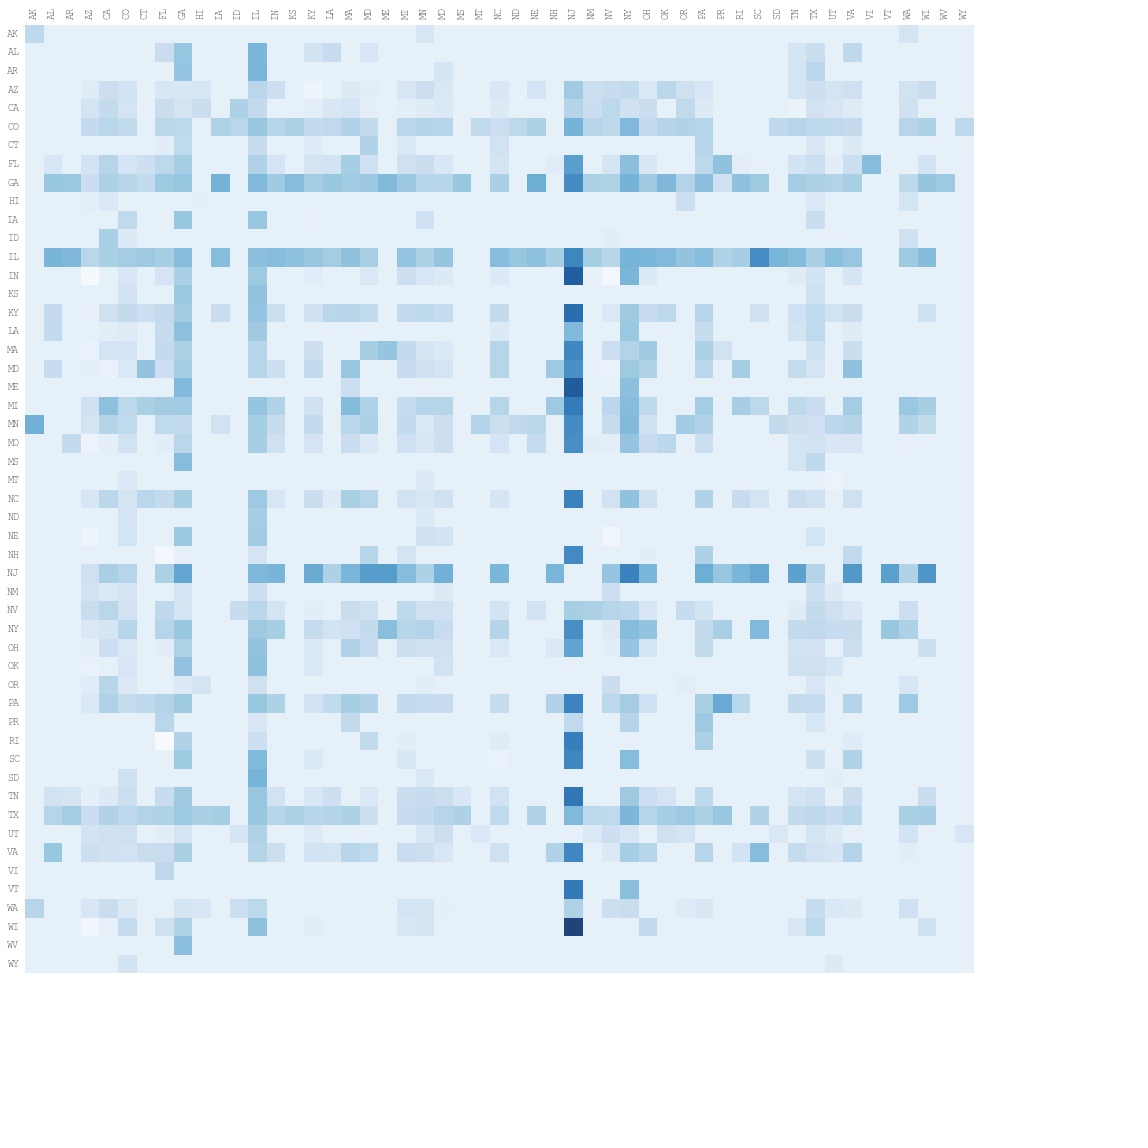

In [46]:
# Plot it out
fig, ax = plt.subplots()
heatmap = ax.pcolor(pivot_airports, cmap=plt.cm.Blues, alpha=0.9)

fig = plt.gcf()
fig.set_size_inches(20,20)

# turn off the frame
ax.set_frame_on(False)

# put the major ticks at the middle of each cell
ax.set_yticks(np.arange(pivot_airports.shape[0])+0.5, minor=False)
ax.set_xticks(np.arange(pivot_airports.shape[1])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(pivot_airports.index, minor=False) 
ax.set_yticklabels(pivot_airports.columns, minor=False)

# rotate the 
plt.xticks(rotation=90)

ax.grid(False)

for t in ax.xaxis.get_major_ticks(): 
    t.tick1On = False 
    t.tick2On = False 
for t in ax.yaxis.get_major_ticks(): 
    t.tick1On = False 
    t.tick2On = False  